In [1]:
!pwd

/home/jakob/htw/imi-master-thesis/notebooks/experiments/ChenConvolutionalNeuralNetworks2017


In [39]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../src/')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)
sns.despine()
import json
import os
from pathlib import Path
import random
from tqdm import tqdm_notebook as tqdm

from models.chen2017.transforms import *
from models.chen2017.preprocess import get_central_labels
import datasets.divahisdb as diva
import experiment.data as exp
import datasets.tiles as tile

from PIL import Image
import numpy as np

env = exp.Environment()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [84]:
fig_path = Path('../../../doc/figures/')

In [4]:
dataset = diva.HisDBDataset(env.dataset(exp.Datasets.diva.value), gt=True)

In [5]:
scaler = Scale()
get_tiles = SegmentTiling()
get_gt = TileGroundTruth()


array([ 0.        ,  0.2       ,  0.4       ,  0.6       ,  0.8       ,
        0.        ,  3.33333333,  6.66666667, 10.        , 13.33333333,
       16.66666667, 20.        , 23.33333333, 26.66666667, 30.        ,
       33.33333333, 36.66666667, 40.        , 43.33333333, 46.66666667,
       50.        , 53.33333333, 56.66666667, 60.        , 63.33333333,
       66.66666667, 70.        , 73.33333333, 76.66666667, 80.        ,
       83.33333333, 86.66666667, 90.        , 93.33333333, 96.66666667])

In [31]:
param1 = 100
params = np.concatenate((np.arange(0.1,1, 0.2), np.arange(0, param1, param1 / 30)))
accuracy = [0] * len(params) 

idx = 0
n_images = 10
rnd = random.Random('slic')
for idx, p in tqdm(enumerate(params), total=len(params)):
    slic = SLIC(n_segments=3000, compactness=p)
    
    crop = tile.RandCrop(500, random.Random('slic'))
    crop_gt = tile.RandCrop(500, random.Random('slic'))
    
    for img_idx in tqdm(range(n_images), total=n_images):
        i = rnd.randrange(0,len(dataset))
        page, gt = dataset[i]
        scaled = scaler(page)
        scaled_gt = np.array(Image.fromarray(gt).resize((scaled.width, scaled.height)))


#         scaled = crop(scaled)
#         scaled_gt = np.array(crop_gt(Image.fromarray(scaled_gt)))


        spixel = slic(scaled)
        tiles, meta = get_tiles(np.array(scaled), spixel)
        tiles_gt, _ = get_tiles(np.array(scaled_gt), spixel)

        segment_id = spixel[(meta[:,0],meta[:,1])]
        segment_gt = scaled_gt[(meta[:,0],meta[:,1])]
        colored = np.zeros(spixel.shape,dtype=np.int)
        for sid, sgt in zip(segment_id, segment_gt):
            colored[np.where(spixel == sid)] = diva.LABEL_DICT[sgt]
        colored = diva.numeric_gt(colored)
        accuracy[idx] += acc(scaled_gt, colored)
    accuracy[idx] = accuracy[idx] / n_images

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/jakob/miniconda3/envs/master/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jakob/miniconda3/envs/master/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jakob/miniconda3/envs/master/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



/home/jakob/miniconda3/envs/master/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = 1.0 / compactness
/home/jakob/miniconda3/envs/master/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:172: RuntimeWarning: invalid value encountered in multiply
  image = np.ascontiguousarray(image * ratio)


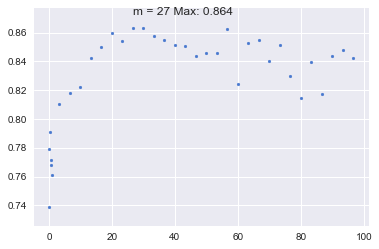

In [90]:
ax= plt.subplot(111)
plt.scatter(params, np.array(accuracy),8)
max_acc = np.max(np.array(accuracy))
max_param = params[np.where(np.array(accuracy) == max_acc)][0]
ax.annotate('m = {:0.2g} Max: {:0.3g}'.format(max_param,max_acc), (max_param,max_acc),  (max_param,max_acc * 1.01))
plt.savefig(fig_path / 'datasets' / 'slic_hyperparameter.pdf')

In [73]:
max_param

26.666666666666668

In [109]:
# Image.fromarray(diva.color_gt(scaled_gt))
# scaled
get_central_labels(scaled_gt, meta)

array([2, 2, 0, ..., 0, 0, 0], dtype=uint8)

In [123]:
meta

array([[  17,  305,   57],
       [  14,  350,   58],
       [  15,   44,   61],
       ...,
       [ 481,  445, 2702],
       [ 483,  474, 2703],
       [ 484,  392, 2705]], dtype=int32)

In [171]:
# y = get_central_labels(scaled_gt, meta)


[(0, 2216), (2, 236), (3, 255)]

In [149]:
meta[:,0],meta[:,1]

(array([ 17,  14,  15, ..., 481, 483, 484], dtype=int32),
 array([305, 350,  44, ..., 445, 474, 392], dtype=int32))

In [170]:
hisdb.LABEL_DICT[1]

<Annotations.DECORATION: 4>

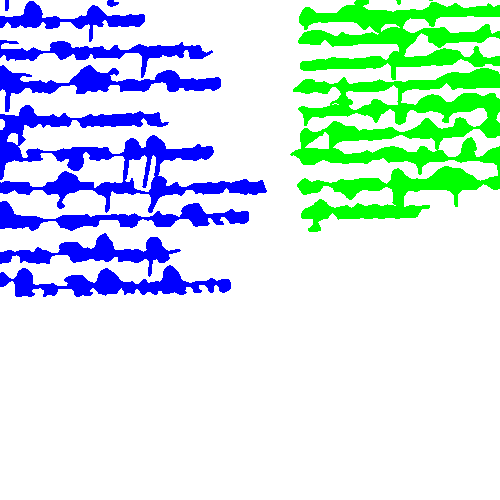

In [161]:
Image.fromarray(diva.color_gt(scaled_gt))

In [8]:
def acc(gt, pred):
    return np.sum(gt == pred) / gt.size

def metrics(gt, pred):
    label_counts = list(zip(*np.unique(gt, return_counts=True)))
    n_c = len(label_counts)
    mean = 0
    iu = 0
    for label, count in label_counts:
        print('label {}'.format(label))
        n_ii = np.sum((gt == pred) & (pred == label))
        t_i  = np.sum((pred == label) )
        sum_n_ji = np.sum((gt != pred) & (gt == label))
        

        mean += n_ii / t_i
        iu   += n_ii / (t_i + sum_n_ji - n_ii)
    return np.sum(gt == pred) / gt.size, mean / n_c, iu / n_c

null = np.zeros(scaled_gt.shape, scaled_gt.dtype)
metrics(scaled_gt, null)

#     list(zip(*np.unique(gt, return_counts=True)))

label 0
label 2
label 3


/home/jakob/miniconda3/envs/master/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


(0.741968, nan, 0.9584961038424175)

In [214]:
list(zip(*np.unique(gt, return_counts=True)))

[(0, 27793624), (1, 148226), (2, 1200992), (3, 2505670)]

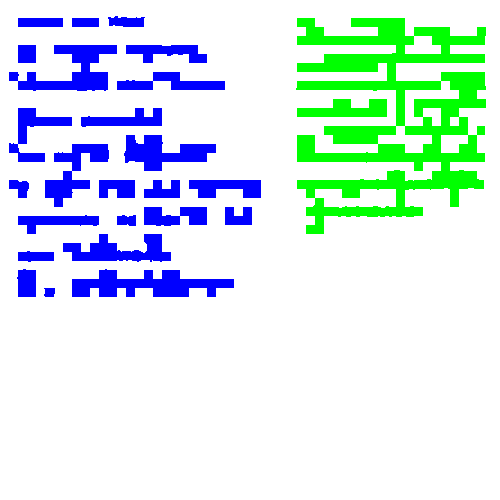

In [220]:
Image.fromarray(diva.color_gt(colored))

In [178]:
patches = tiles_gt
if len(patches.shape) > 3:
    n, height, width, channels = patches.shape
    big_img = np.zeros((n_images * height, n_images * width, channels), dtype=patches.dtype)
else:
    n, height, width, channels = *patches.shape, 1
    big_img = np.zeros((n_images * height, n_images * width), dtype=patches.dtype)
n_images = 16


for m in range(n_images):
    for n in range(n_images):
        idx = m * n_images + n
        if channels == 1:
            big_img[m*height: (m+1)*height, n*width:(n+1)*width] = patches[idx]
        else:
            big_img[m*height: (m+1)*height, n*width:(n+1)*width,:] = patches[idx]

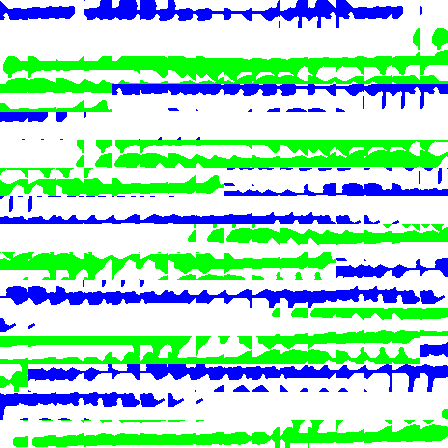

In [179]:

Image.fromarray(diva.color_gt(big_img))

In [94]:
patches.shape


(2725, 28, 28)